In [1]:
import torch
import matplotlib

prefix = "../experiments"

metric_name_to_model_name_to_metric_mean = {
    "wasserstein2":{},
    "quantile_error":{},
    "gaussian_negative_log_likelihood":{}
}
metric_name_to_model_name_to_metric_std = {
    "wasserstein2":{},
    "quantile_error":{},
    "gaussian_negative_log_likelihood":{}
}
(
    model_name_to_idx,
    idx_to_model_name,
    model_name_to_color
) = {}, {}, {}

model_name_to_metric_path = {
    "CPFlow":"convex_potential_flow/metrics.pth",
    "CPFlow_5000":"convex_potential_flow_5000/metrics.pth",
    "EntropicOTQuantileRegression/Softplus":"entropic_optimal_transport_quantile_regression/metrics.pth",
    "EntropicOTQuantileRegression/PICNN":"picnn_entropic_optimal_transport_quantile_regression/metrics.pth",
    "UnconstrainedAmortizedOTQuantileRegression":"unconstrained_amortized_optimal_transport_quantile_regression/metrics.pth",
    "UnconstrainedOTQuantileRegression":"unconstrained_optimal_transport_quantile_regression/metrics.pth"
}

for idx, (model_name, path_to_metric) in enumerate(model_name_to_metric_path.items()):
    model_name_to_idx[model_name] = idx
    idx_to_model_name[idx] = model_name
    model_name_to_color = matplotlib.colormaps['hsv'](idx / len(model_name_to_metric_path))
    metrics_dict = torch.load(f"{prefix}/{path_to_metric}", torch.device("cpu"))

    wasserstein2_metric = metrics_dict['wasserstein2']
    number_of_XY_samples = wasserstein2_metric.shape[0]
    wasserstein2_mean = wasserstein2_metric.mean()
    wasserstein2_std = torch.sqrt(wasserstein2_metric.cov().sum()) / number_of_XY_samples
    metric_name_to_model_name_to_metric_std['wasserstein2'][model_name] = wasserstein2_std.item()
    metric_name_to_model_name_to_metric_mean['wasserstein2'][model_name] = wasserstein2_mean.item()

    quantile_error_metric = metrics_dict['quantile_error'].mean(dim=-1)
    quantile_error_mean = quantile_error_metric.mean()
    quantile_error_std = torch.sqrt(quantile_error_metric.cov().sum()) / number_of_XY_samples
    metric_name_to_model_name_to_metric_std['quantile_error'][model_name] = quantile_error_std.item()
    metric_name_to_model_name_to_metric_mean['quantile_error'][model_name] = quantile_error_mean.item()

    gaussian_negative_log_likelihood_metric = metrics_dict['gaussian_negative_log_likelihood']
    gaussian_negative_log_likelihood_mean = gaussian_negative_log_likelihood_metric.mean()
    gaussian_negative_log_likelihood_std = torch.sqrt(gaussian_negative_log_likelihood_metric.cov().sum()) / number_of_XY_samples
    metric_name_to_model_name_to_metric_mean['gaussian_negative_log_likelihood'][model_name] = gaussian_negative_log_likelihood_mean.item()
    metric_name_to_model_name_to_metric_std['gaussian_negative_log_likelihood'][model_name] = gaussian_negative_log_likelihood_std.item()

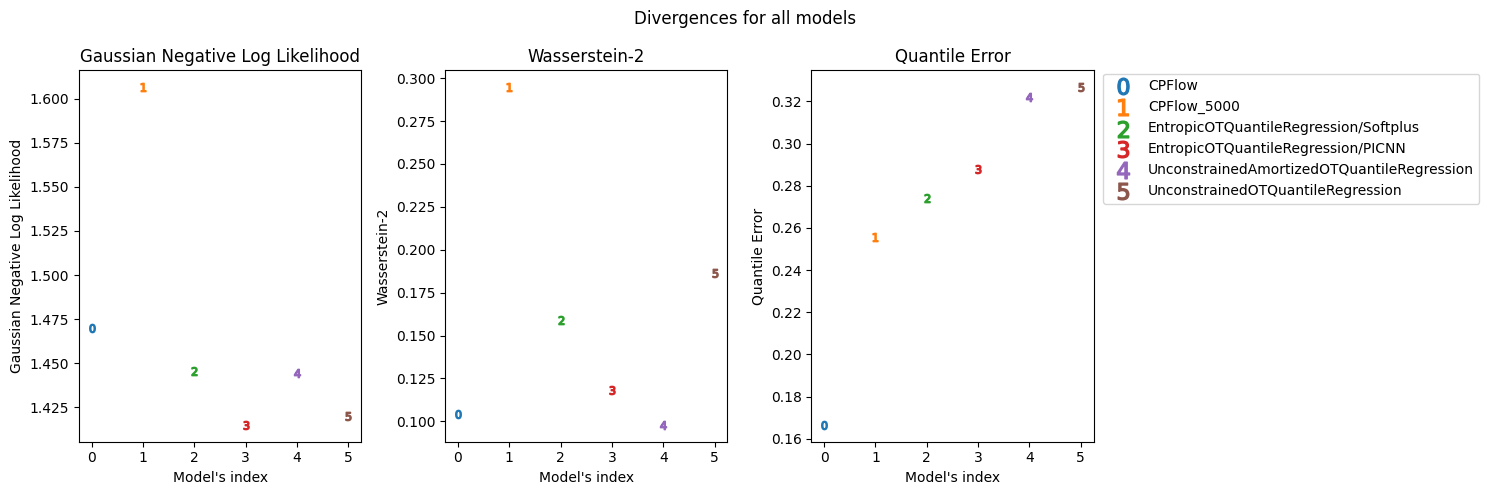

In [2]:
import matplotlib.pyplot as plt

prefix = "../experiments/banana"
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

fig.suptitle("Divergences for all models")

ax1.set_title("Gaussian Negative Log Likelihood")
ax1.set_xlabel("Model's index")
ax1.set_ylabel("Gaussian Negative Log Likelihood")

ax2.set_title("Wasserstein-2")
ax2.set_xlabel("Model's index")
ax2.set_ylabel("Wasserstein-2")

ax3.set_title("Quantile Error")
ax3.set_xlabel("Model's index")
ax3.set_ylabel("Quantile Error")

for model_name, idx in model_name_to_idx.items():
    gaussian_likelihood = metric_name_to_model_name_to_metric_mean["gaussian_negative_log_likelihood"][model_name]
    wasserstein2 = metric_name_to_model_name_to_metric_mean["wasserstein2"][model_name]
    quantile_error = metric_name_to_model_name_to_metric_mean["quantile_error"][model_name]

    ax1.scatter(idx, gaussian_likelihood, marker=f'${idx}$', label=model_name)
    ax2.scatter(idx, wasserstein2, marker=f'${idx}$', label=model_name)
    ax3.scatter(idx, quantile_error, marker=f'${idx}$', label=model_name)

ax3.legend(markerscale=2, bbox_to_anchor=[1.01, 1.01], loc='upper left')
plt.tight_layout()
plt.show()

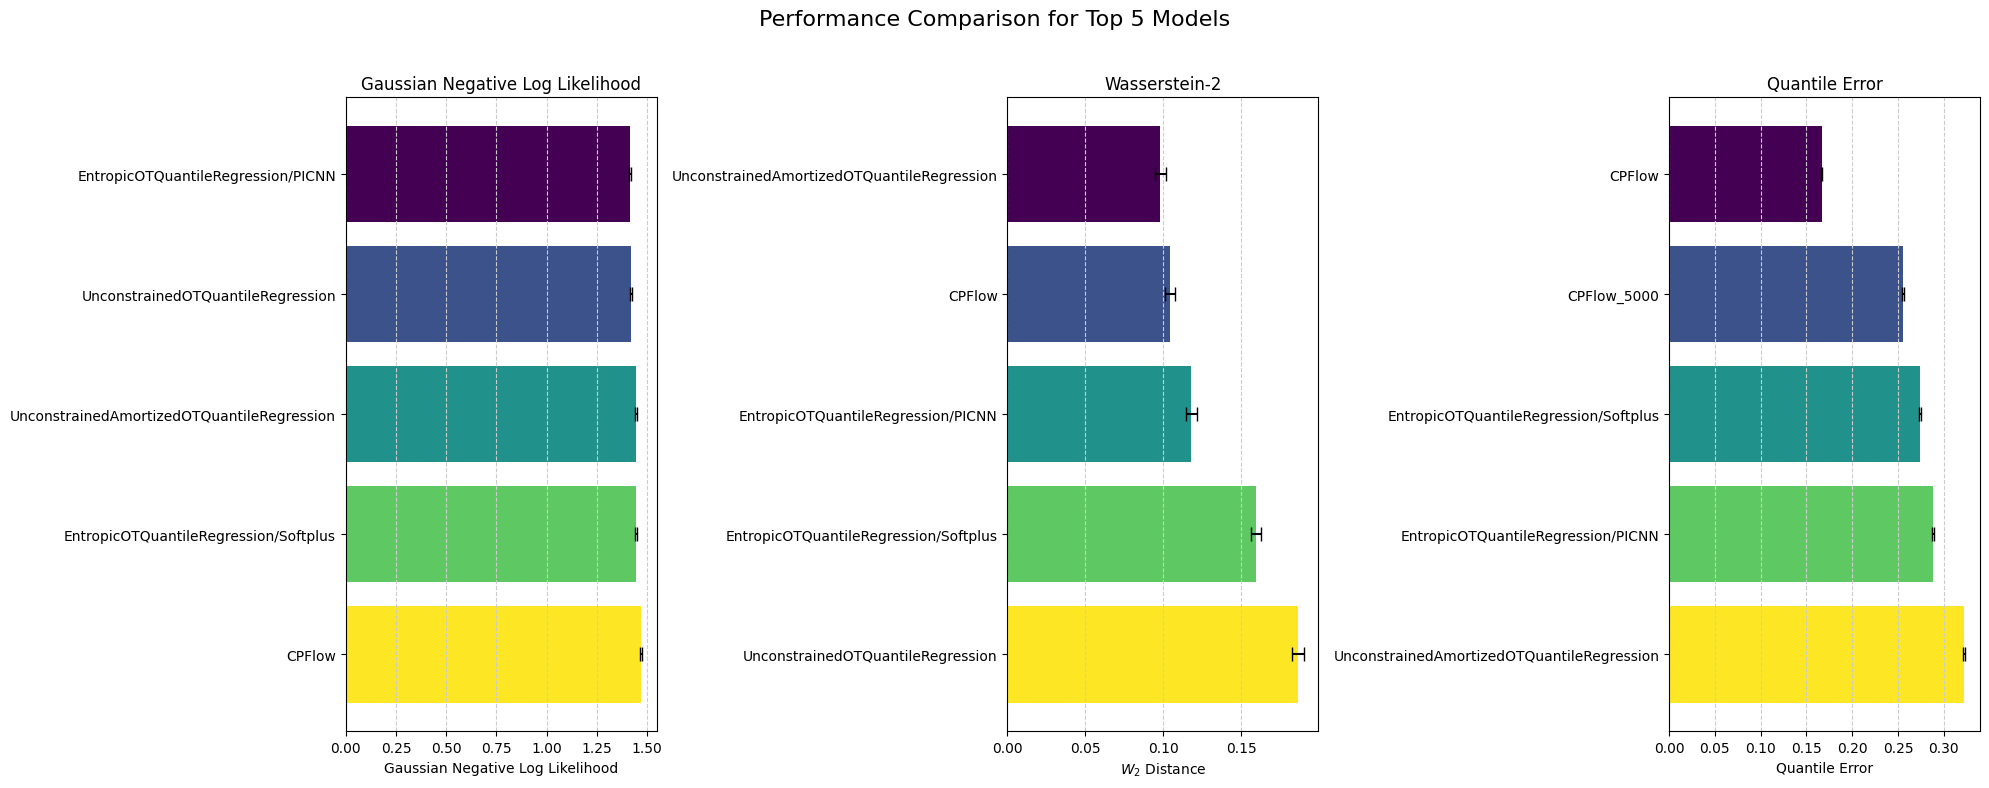

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
fig.suptitle("Performance Comparison for Top 5 Models", fontsize=16)

index_to_metric = {}

all_indices = []
all_wasserstein2, all_wasserstein2_stds = [], []
all_quantile_error, all_quantile_error_stds = [], []
all_gaussian_negative_log_likelihood, all_gaussian_negative_log_likelihood_stds = [], []

for model_name, idx in model_name_to_idx.items():
    gaussian_negative_log_likelihood_mean = metric_name_to_model_name_to_metric_mean["gaussian_negative_log_likelihood"][model_name]
    wasserstein2_mean = metric_name_to_model_name_to_metric_mean["wasserstein2"][model_name]
    quantile_error_mean = metric_name_to_model_name_to_metric_mean["quantile_error"][model_name]

    gaussian_negative_log_likelihood_std = metric_name_to_model_name_to_metric_std["gaussian_negative_log_likelihood"][model_name]
    wasserstein2_std = metric_name_to_model_name_to_metric_std["wasserstein2"][model_name]
    quantile_error_std = metric_name_to_model_name_to_metric_std["quantile_error"][model_name]

    all_wasserstein2.append(wasserstein2_mean)
    all_quantile_error.append(quantile_error_mean)
    all_gaussian_negative_log_likelihood.append(gaussian_negative_log_likelihood_mean)

    all_wasserstein2_stds.append(wasserstein2_std)
    all_quantile_error_stds.append(quantile_error_std)
    all_gaussian_negative_log_likelihood_stds.append(gaussian_negative_log_likelihood_std)

    all_indices.append(idx)

all_wasserstein2_tensor = torch.tensor(all_wasserstein2)
all_quantile_error_tensor = torch.tensor(all_quantile_error)
all_gaussian_negative_log_likelihood_tensor = torch.tensor(all_gaussian_negative_log_likelihood)

top_5_gaussian_negative_log_likelihood_models = all_gaussian_negative_log_likelihood_tensor.argsort()[:5]
top_5_wasserstein2_models = all_wasserstein2_tensor.argsort()[:5]
top_5_quantile_error_models = all_quantile_error_tensor.argsort()[:5]

def plot_barchart(axis, title, metric_name, top_indices, model_name_to_metric_mean, model_name_to_metric_std, lower_is_better=True):
    axis.set_title(title)

    model_names = [idx_to_model_name[i.item()] for i in top_indices]
    means = [model_name_to_metric_mean[model_name] for model_name in model_names]
    stds = [model_name_to_metric_std[model_name] for model_name in model_names]

    sorted_data = sorted(zip(means, stds, model_names), reverse=not lower_is_better)
    sorted_means, sorted_stds, sorted_names = zip(*sorted_data)

    y_pos = np.arange(len(sorted_names))
    colors = plt.cm.viridis(np.linspace(0, 1, len(y_pos)))

    axis.barh(y_pos, sorted_means, xerr=sorted_stds, align='center', color=colors, capsize=5)
    axis.set_yticks(y_pos)
    axis.set_yticklabels(sorted_names)
    axis.invert_yaxis()
    axis.set_xlabel(metric_name)
    axis.grid(True, which="major", axis='x', ls="--", c='0.8')

plot_barchart(
    axis=ax1,
    title="Gaussian Negative Log Likelihood",
    metric_name="Gaussian Negative Log Likelihood",
    top_indices=top_5_gaussian_negative_log_likelihood_models,
    model_name_to_metric_mean=metric_name_to_model_name_to_metric_mean["gaussian_negative_log_likelihood"],
    model_name_to_metric_std=metric_name_to_model_name_to_metric_std["gaussian_negative_log_likelihood"],
    lower_is_better=True
)

plot_barchart(
    axis=ax2,
    title="Wasserstein-2",
    metric_name="$W_2$ Distance",
    top_indices=top_5_wasserstein2_models,
    model_name_to_metric_mean=metric_name_to_model_name_to_metric_mean["wasserstein2"],
    model_name_to_metric_std=metric_name_to_model_name_to_metric_std["wasserstein2"],
    lower_is_better=True
)

plot_barchart(
    axis=ax3,
    title="Quantile Error",
    metric_name="Quantile Error",
    top_indices=top_5_quantile_error_models,
    model_name_to_metric_mean=metric_name_to_model_name_to_metric_mean["quantile_error"],
    model_name_to_metric_std=metric_name_to_model_name_to_metric_std["quantile_error"],
    lower_is_better=True
)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [4]:
import matplotlib.pyplot as plt

models_names_from_epsilon_experiment = [model_name for model_name in model_name_to_idx.keys() if "Epsilon" in model_name]

epsilons = []
all_gaussian_negative_log_likelihood_means, all_gaussian_negative_log_likelihood_stds = [], []
all_wasserstein2_means, all_wasserstein2_stds = [], []
all_quantile_error_means, all_quantile_error_stds = [], []

for model_name in models_names_from_epsilon_experiment:
    try:
        epsilon_str = model_name.split('/')[-1].replace('_', '-')
        epsilons.append(float(epsilon_str))
    except (ValueError, IndexError):
        print(f"Warning: Could not parse epsilon from path: {model_name}")
        continue

    gaussian_negative_log_likelihood_mean = metric_name_to_model_name_to_metric_mean["gaussian_negative_log_likelihood"][model_name]
    wasserstein2_mean = metric_name_to_model_name_to_metric_mean["wasserstein2"][model_name]
    quantile_error_mean = metric_name_to_model_name_to_metric_mean["quantile_error"][model_name]

    gaussian_negative_log_likelihood_std = metric_name_to_model_name_to_metric_std["gaussian_negative_log_likelihood"][model_name]
    wasserstein2_std = metric_name_to_model_name_to_metric_std["wasserstein2"][model_name]
    quantile_error_std = metric_name_to_model_name_to_metric_std["quantile_error"][model_name]

    all_gaussian_negative_log_likelihood_means.append(gaussian_negative_log_likelihood_mean)
    all_wasserstein2_means.append(wasserstein2_mean)
    all_quantile_error_means.append(quantile_error_mean)

    all_gaussian_negative_log_likelihood_stds.append(gaussian_negative_log_likelihood_std)
    all_wasserstein2_stds.append(wasserstein2_std)
    all_quantile_error_stds.append(quantile_error_std)

if epsilons:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle("Divergences vs. Epsilon for Entropic OT")

    ax1.set_title("Gaussian Negative Log Likelihood")
    ax1.set_ylabel("Gaussian Negative Log Likelihood")

    ax2.set_title("Wasserstein-2")
    ax2.set_ylabel("Wasserstein-2")

    ax3.set_title("Quantile Error")
    ax3.set_ylabel("Quantile Error")

    sorted_data = sorted(zip(
        epsilons,
        all_gaussian_negative_log_likelihood_means, all_gaussian_negative_log_likelihood_stds,
        all_wasserstein2_means, all_wasserstein2_stds,
        all_quantile_error_means, all_quantile_error_stds
    ))

    (
        sorted_epsilons,
        sorted_gaussian_negative_log_likelihood_means, sorted_gaussian_negative_log_likelihood_stds,
        sorted_wasserstein2_means, sorted_wasserstein2_stds,
        sorted_quantile_error_means, sorted_quantile_error_stds
    ) = zip(*sorted_data)

    common_errorbar_settings = {'fmt': '-o', 'capsize': 5, 'elinewidth': 1.5, 'markersize': 6, 'color': 'royalblue', 'markerfacecolor': 'royalblue'}

    ax1.errorbar(sorted_epsilons, sorted_gaussian_negative_log_likelihood_means, yerr=sorted_gaussian_negative_log_likelihood_stds, **common_errorbar_settings)
    ax2.errorbar(sorted_epsilons, sorted_wasserstein2_means, yerr=sorted_wasserstein2_stds, **common_errorbar_settings)
    ax3.errorbar(sorted_epsilons, sorted_quantile_error_means, yerr=sorted_quantile_error_stds, **common_errorbar_settings)

    for ax in [ax1, ax2, ax3]:
        ax.set_xscale('log')
        ax.set_xlabel("Epsilon")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print("No data to plot")

No data to plot


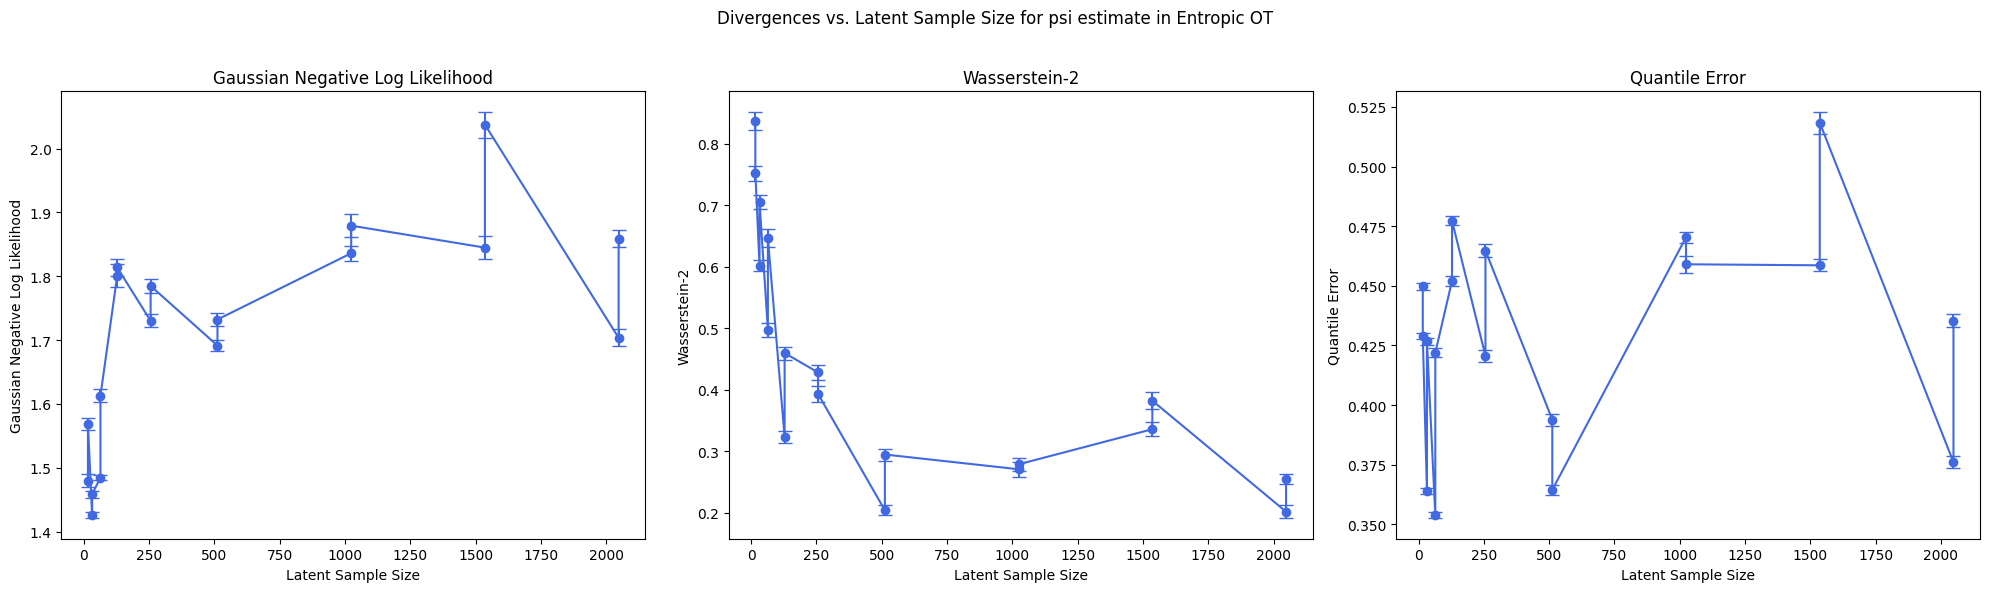

In [38]:
import matplotlib.pyplot as plt

models_names_from_batch_variations_experiment = [model_name for model_name in model_name_to_idx.keys() if "LatentSampleSize" in model_name]

latent_sample_sizes = []
all_gaussian_negative_log_likelihood_means, all_gaussian_negative_log_likelihood_stds = [], []
all_wasserstein2_means, all_wasserstein2_stds = [], []
all_quantile_error_means, all_quantile_error_stds = [], []

for model_name in models_names_from_batch_variations_experiment:
    try:
        latent_sample_size_str = model_name.split('/')[-1]
        latent_sample_sizes.append(int(latent_sample_size_str))
    except (ValueError, IndexError):
        print(f"Warning: Could not parse latent sample size from path: {model_name}")
        continue


    gaussian_negative_log_likelihood_mean = metric_name_to_model_name_to_metric_mean["gaussian_negative_log_likelihood"][model_name]
    wasserstein2_mean = metric_name_to_model_name_to_metric_mean["wasserstein2"][model_name]
    quantile_error_mean = metric_name_to_model_name_to_metric_mean["quantile_error"][model_name]

    gaussian_negative_log_likelihood_std = metric_name_to_model_name_to_metric_std["gaussian_negative_log_likelihood"][model_name]
    wasserstein2_std = metric_name_to_model_name_to_metric_std["wasserstein2"][model_name]
    quantile_error_std = metric_name_to_model_name_to_metric_std["quantile_error"][model_name]

    all_gaussian_negative_log_likelihood_means.append(gaussian_negative_log_likelihood_mean)
    all_wasserstein2_means.append(wasserstein2_mean)
    all_quantile_error_means.append(quantile_error_mean)

    all_gaussian_negative_log_likelihood_stds.append(gaussian_negative_log_likelihood_std)
    all_wasserstein2_stds.append(wasserstein2_std)
    all_quantile_error_stds.append(quantile_error_std)

if latent_sample_sizes:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle("Divergences vs. Latent Sample Size for psi estimate in Entropic OT")

    ax1.set_title("Gaussian Negative Log Likelihood")
    ax1.set_ylabel("Gaussian Negative Log Likelihood")

    ax2.set_title("Wasserstein-2")
    ax2.set_ylabel("Wasserstein-2")

    ax3.set_title("Quantile Error")
    ax3.set_ylabel("Quantile Error")

    sorted_data = sorted(zip(
        latent_sample_sizes,
        all_gaussian_negative_log_likelihood_means, all_gaussian_negative_log_likelihood_stds,
        all_wasserstein2_means, all_wasserstein2_stds,
        all_quantile_error_means, all_quantile_error_stds
    ))

    (
        sorted_latent_sample_sizes,
        sorted_gaussian_negative_log_likelihood_means, sorted_gaussian_negative_log_likelihood_stds,
        sorted_wasserstein2_means, sorted_wasserstein2_stds,
        sorted_quantile_error_means, sorted_quantile_error_stds
    ) = zip(*sorted_data)

    common_errorbar_settings = {'fmt': '-o', 'capsize': 5, 'elinewidth': 1.5, 'markersize': 6, 'color': 'royalblue', 'markerfacecolor': 'royalblue'}
    ax1.errorbar(sorted_latent_sample_sizes, sorted_gaussian_negative_log_likelihood_means, yerr=sorted_gaussian_negative_log_likelihood_stds, **common_errorbar_settings)
    ax2.errorbar(sorted_latent_sample_sizes, sorted_wasserstein2_means, yerr=sorted_wasserstein2_stds, **common_errorbar_settings)
    ax3.errorbar(sorted_latent_sample_sizes, sorted_quantile_error_means, yerr=sorted_quantile_error_stds, **common_errorbar_settings)

    for ax in [ax1, ax2, ax3]:
        ax.set_xlabel("Latent Sample Size")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print("No data to plot")

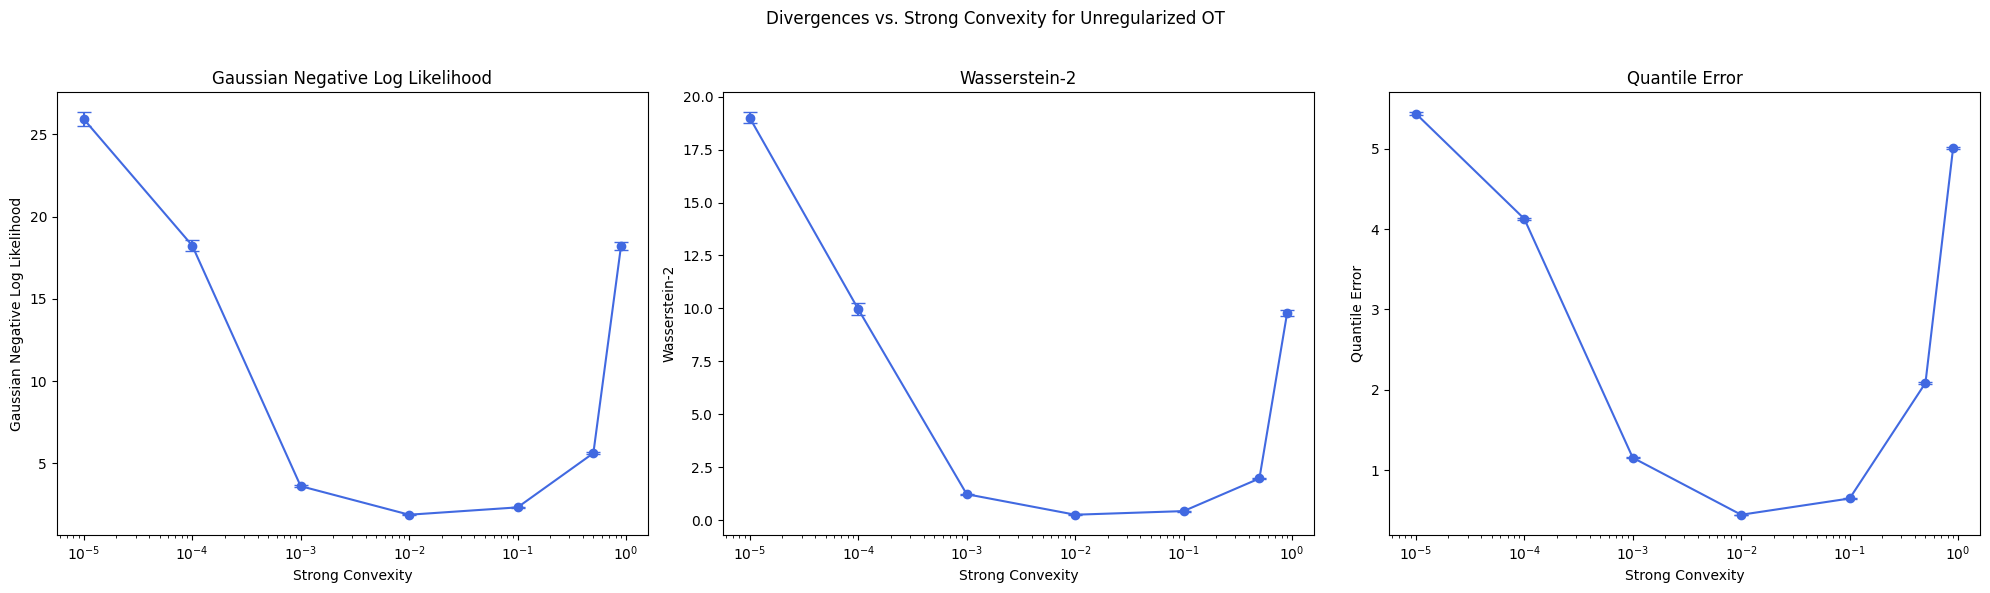

In [39]:
import matplotlib.pyplot as plt

models_names_from_strong_convexity_experiment = [model_name for model_name in model_name_to_idx.keys() if "UnconstrainedOTQuantileRegression" in model_name]

strong_convexity_values = []
all_gaussian_negative_log_likelihood_means, all_gaussian_negative_log_likelihood_stds = [], []
all_wasserstein2_means, all_wasserstein2_stds = [], []
all_quantile_error_means, all_quantile_error_stds = [], []

for model_name in models_names_from_strong_convexity_experiment:
    try:
        strong_convexity_value_str = model_name.split('/')[-1].replace('_', '-')
        strong_convexity_values.append(float(strong_convexity_value_str))
    except (ValueError, IndexError):
        print(f"Warning: Could not parse strong convexity value from path: {model_name}")
        continue

    gaussian_negative_log_likelihood_mean = metric_name_to_model_name_to_metric_mean["gaussian_negative_log_likelihood"][model_name]
    wasserstein2_mean = metric_name_to_model_name_to_metric_mean["wasserstein2"][model_name]
    quantile_error_mean = metric_name_to_model_name_to_metric_mean["quantile_error"][model_name]

    gaussian_negative_log_likelihood_std = metric_name_to_model_name_to_metric_std["gaussian_negative_log_likelihood"][model_name]
    wasserstein2_std = metric_name_to_model_name_to_metric_std["wasserstein2"][model_name]
    quantile_error_std = metric_name_to_model_name_to_metric_std["quantile_error"][model_name]

    all_gaussian_negative_log_likelihood_means.append(gaussian_negative_log_likelihood_mean)
    all_wasserstein2_means.append(wasserstein2_mean)
    all_quantile_error_means.append(quantile_error_mean)

    all_gaussian_negative_log_likelihood_stds.append(gaussian_negative_log_likelihood_std)
    all_wasserstein2_stds.append(wasserstein2_std)
    all_quantile_error_stds.append(quantile_error_std)

if strong_convexity_values:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle("Divergences vs. Strong Convexity for Unregularized OT")

    ax1.set_title("Gaussian Negative Log Likelihood")
    ax1.set_ylabel("Gaussian Negative Log Likelihood")

    ax2.set_title("Wasserstein-2")
    ax2.set_ylabel("Wasserstein-2")

    ax3.set_title("Quantile Error")
    ax3.set_ylabel("Quantile Error")

    sorted_data = sorted(zip(
        strong_convexity_values,
        all_gaussian_negative_log_likelihood_means, all_gaussian_negative_log_likelihood_stds,
        all_wasserstein2_means, all_wasserstein2_stds,
        all_quantile_error_means, all_quantile_error_stds
    ))

    (
        sorted_strong_convexity_values,
        sorted_gaussian_negative_log_likelihood_means, sorted_gaussian_negative_log_likelihood_stds,
        sorted_wasserstein2_means, sorted_wasserstein2_stds,
        sorted_quantile_error_means, sorted_quantile_error_stds
    ) = zip(*sorted_data)

    common_errorbar_settings = {'fmt': '-o', 'capsize': 5, 'elinewidth': 1.5, 'markersize': 6, 'color': 'royalblue', 'markerfacecolor': 'royalblue'}

    ax1.errorbar(sorted_strong_convexity_values, sorted_gaussian_negative_log_likelihood_means, yerr=sorted_gaussian_negative_log_likelihood_stds, **common_errorbar_settings)
    ax2.errorbar(sorted_strong_convexity_values, sorted_wasserstein2_means, yerr=sorted_wasserstein2_stds, **common_errorbar_settings)
    ax3.errorbar(sorted_strong_convexity_values, sorted_quantile_error_means, yerr=sorted_quantile_error_stds, **common_errorbar_settings)

    for ax in [ax1, ax2, ax3]:
        ax.set_xscale('log')
        ax.set_xlabel("Strong Convexity")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print("No data to plot")

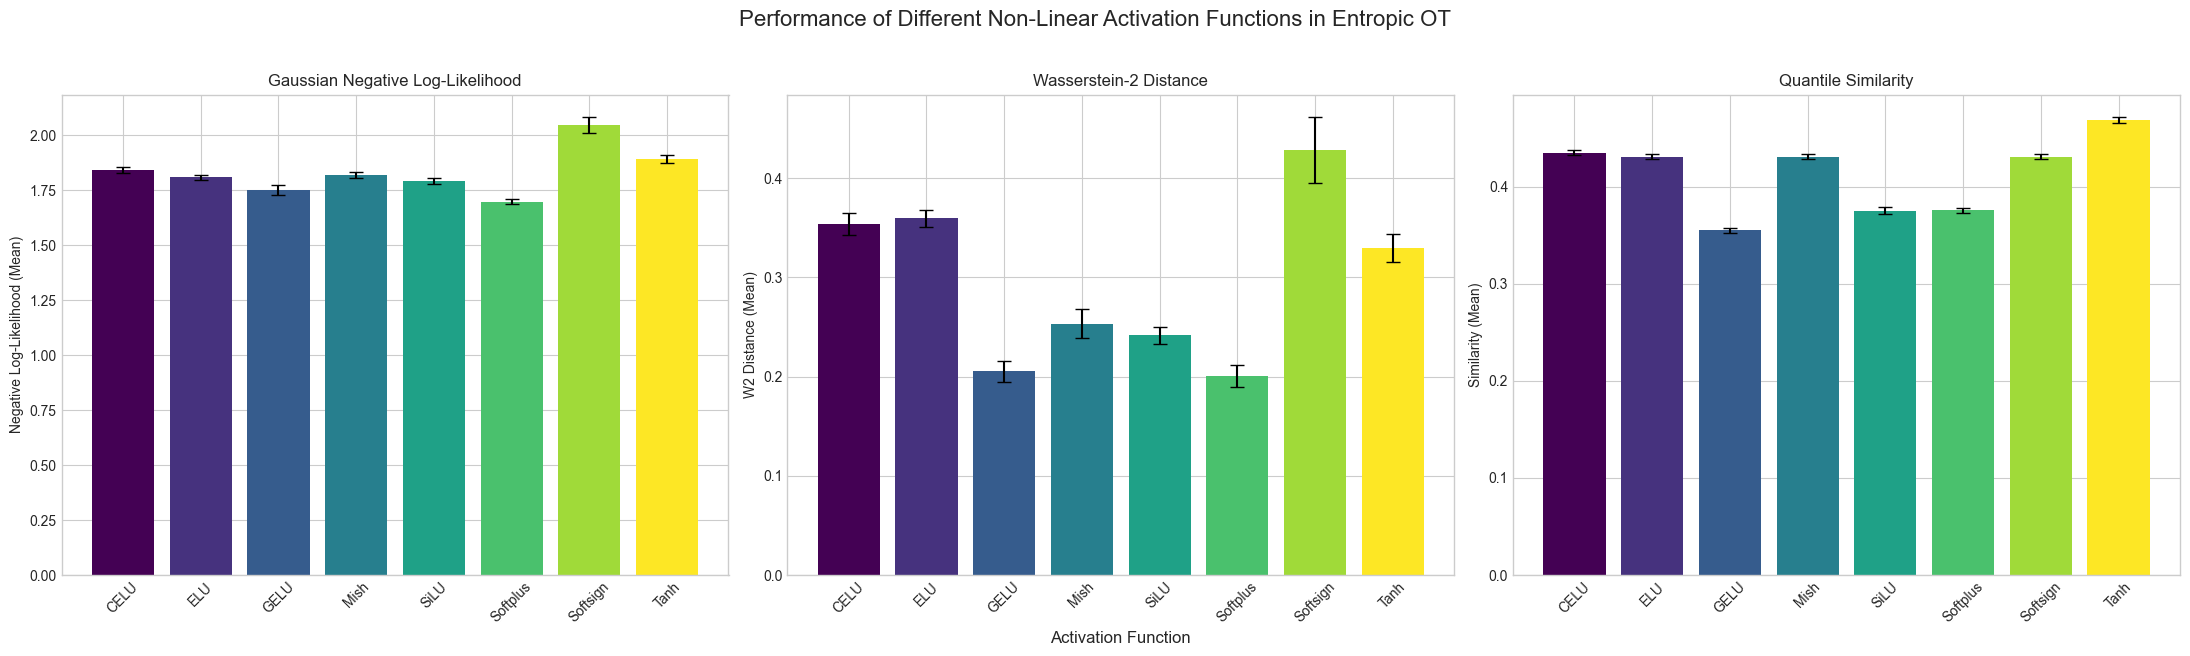

In [45]:
import matplotlib.pyplot as plt
import torch

model_name_to_activation_function_name = {
    "EntropicOTQuantileRegression/CELU":"CELU",
    "EntropicOTQuantileRegression/ELU":"ELU",
    "EntropicOTQuantileRegression/GELU":"GELU",
    "EntropicOTQuantileRegression/Mish":"Mish",
    "EntropicOTQuantileRegression/SiLU":"SiLU",
    "EntropicOTQuantileRegression/Softplus":"Softplus",
    "EntropicOTQuantileRegression/Softsign":"Softsign",
    "EntropicOTQuantileRegression/Tanh":"Tanh",
}

plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 7))
fig.suptitle("Performance of Different Non-Linear Activation Functions in Entropic OT", fontsize=16)

colors = plt.cm.viridis(torch.linspace(0, 1, len(model_name_to_activation_function_name)))

ax1.bar(
    model_name_to_activation_function_name.values(),
    [
        metric_name_to_model_name_to_metric_mean["gaussian_negative_log_likelihood"][name] for name in model_name_to_activation_function_name.keys()
    ],
    yerr=[
        metric_name_to_model_name_to_metric_std["gaussian_negative_log_likelihood"][name] for name in model_name_to_activation_function_name.keys()
    ],
    color=colors,
    capsize=5
)
ax1.set_title("Gaussian Negative Log-Likelihood")
ax1.set_ylabel("Negative Log-Likelihood (Mean)")

ax2.bar(
    model_name_to_activation_function_name.values(),
        [
        metric_name_to_model_name_to_metric_mean["wasserstein2"][name] for name in model_name_to_activation_function_name.keys()
    ],
    yerr=[
        metric_name_to_model_name_to_metric_std["wasserstein2"][name] for name in model_name_to_activation_function_name.keys()
    ],
    color=colors,
    capsize=5
)
ax2.set_title("Wasserstein-2 Distance")
ax2.set_ylabel("W2 Distance (Mean)")
ax2.set_xlabel("Activation Function", fontsize=12)

ax3.bar(
    model_name_to_activation_function_name.values(),
    [
        metric_name_to_model_name_to_metric_mean["quantile_error"][name] for name in model_name_to_activation_function_name.keys()
    ],
    yerr=[
        metric_name_to_model_name_to_metric_std["quantile_error"][name] for name in model_name_to_activation_function_name.keys()
    ],
    color=colors, capsize=5)
ax3.set_title("Quantile Similarity")
ax3.set_ylabel("Similarity (Mean)")

for ax in [ax1, ax2, ax3]:
    ax.tick_params(axis='x', rotation=45)
    ax.set_axisbelow(True)

plt.tight_layout(rect=[0, 0.05, 1, 0.96])
plt.show()

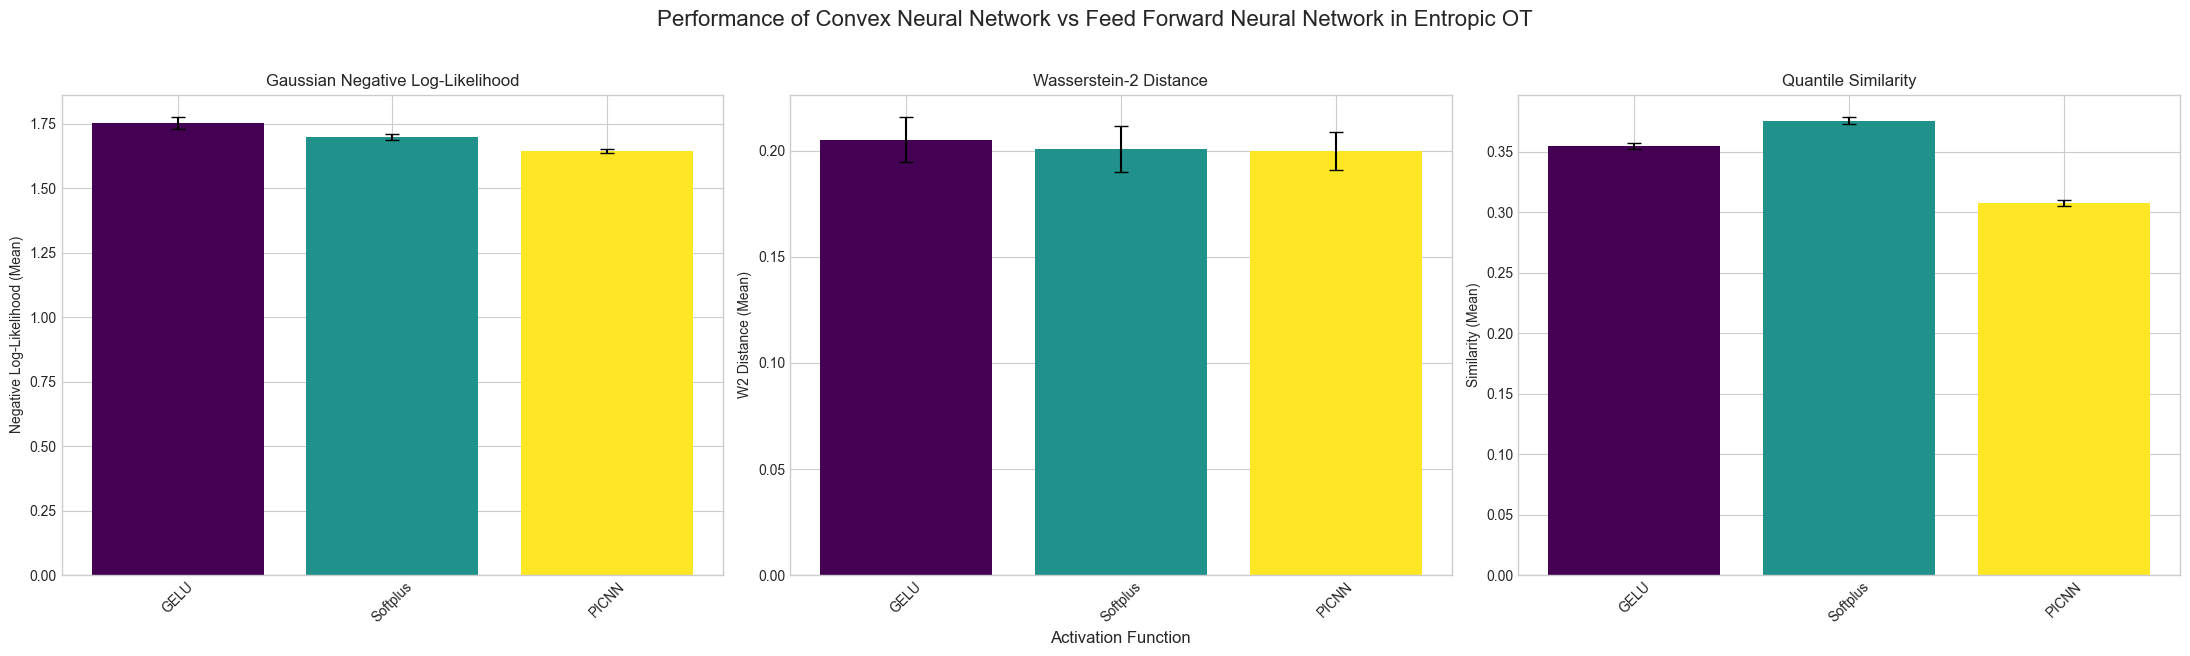

In [44]:
import matplotlib.pyplot as plt
import torch

model_name_to_activation_function_name = {
    "EntropicOTQuantileRegression/GELU":"GELU",
    "EntropicOTQuantileRegression/Softplus":"Softplus",
    "EntropicOTQuantileRegression/PICNN":"PICNN",
}

plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 7))
fig.suptitle("Performance of Convex Neural Network vs Feed Forward Neural Network in Entropic OT", fontsize=16)

colors = plt.cm.viridis(torch.linspace(0, 1, len(model_name_to_activation_function_name)))

ax1.bar(
    model_name_to_activation_function_name.values(),
    [
        metric_name_to_model_name_to_metric_mean["gaussian_negative_log_likelihood"][name] for name in model_name_to_activation_function_name.keys()
    ],
    yerr=[
        metric_name_to_model_name_to_metric_std["gaussian_negative_log_likelihood"][name] for name in model_name_to_activation_function_name.keys()
    ],
    color=colors,
    capsize=5
)
ax1.set_title("Gaussian Negative Log-Likelihood")
ax1.set_ylabel("Negative Log-Likelihood (Mean)")

ax2.bar(
    model_name_to_activation_function_name.values(),
        [
        metric_name_to_model_name_to_metric_mean["wasserstein2"][name] for name in model_name_to_activation_function_name.keys()
    ],
    yerr=[
        metric_name_to_model_name_to_metric_std["wasserstein2"][name] for name in model_name_to_activation_function_name.keys()
    ],
    color=colors,
    capsize=5
)
ax2.set_title("Wasserstein-2 Distance")
ax2.set_ylabel("W2 Distance (Mean)")
ax2.set_xlabel("Activation Function", fontsize=12)

ax3.bar(
    model_name_to_activation_function_name.values(),
    [
        metric_name_to_model_name_to_metric_mean["quantile_error"][name] for name in model_name_to_activation_function_name.keys()
    ],
    yerr=[
        metric_name_to_model_name_to_metric_std["quantile_error"][name] for name in model_name_to_activation_function_name.keys()
    ],
    color=colors, capsize=5)
ax3.set_title("Quantile Similarity")
ax3.set_ylabel("Similarity (Mean)")

for ax in [ax1, ax2, ax3]:
    ax.tick_params(axis='x', rotation=45)
    ax.set_axisbelow(True)

plt.tight_layout(rect=[0, 0.05, 1, 0.96])
plt.show()